1.8.1+cu101
None
Epoch: 01, Test: 0.9423
Epoch: 02, Test: 0.9369
Epoch: 03, Test: 0.9526
Epoch: 04, Test: 0.9382
Epoch: 05, Test: 0.9502
Epoch: 06, Test: 0.9688
Epoch: 07, Test: 0.9692
Epoch: 08, Test: 0.9697
Epoch: 09, Test: 0.9705
Epoch: 10, Test: 0.9710
Epoch: 11, Test: 0.9686
Epoch: 12, Test: 0.9703
Epoch: 13, Test: 0.9686
Epoch: 14, Test: 0.9712
Epoch: 15, Test: 0.9682
Epoch: 16, Test: 0.9708
Epoch: 17, Test: 0.9709
Epoch: 18, Test: 0.9713
Epoch: 19, Test: 0.9706
running pca
pca time 0.7237691879272461
silhouette average 0.14388032 std 0.29018673
davies bouldin score 2.1472096386044868
calinski harabasz score 32746.687231771917


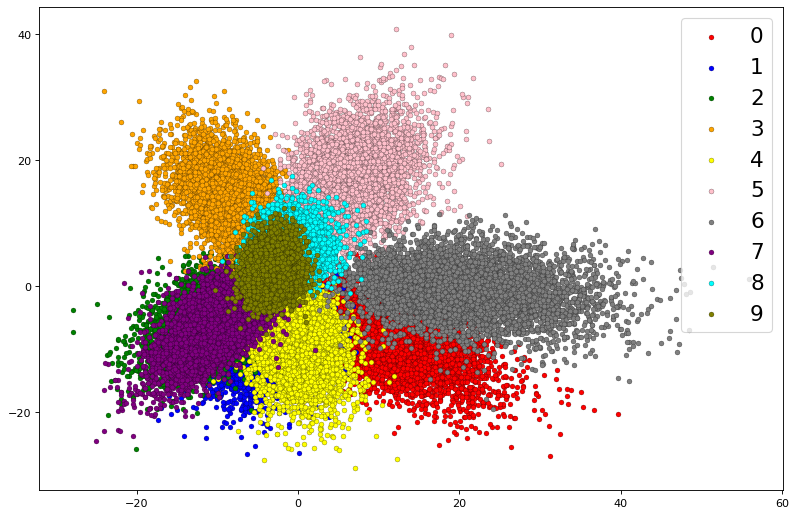

running tsne
tsne time 2418.4808406829834
silhouette average 0.57194525 std 0.16248839
davies bouldin score 0.5682381867731323
calinski harabasz score 105784.03370012855


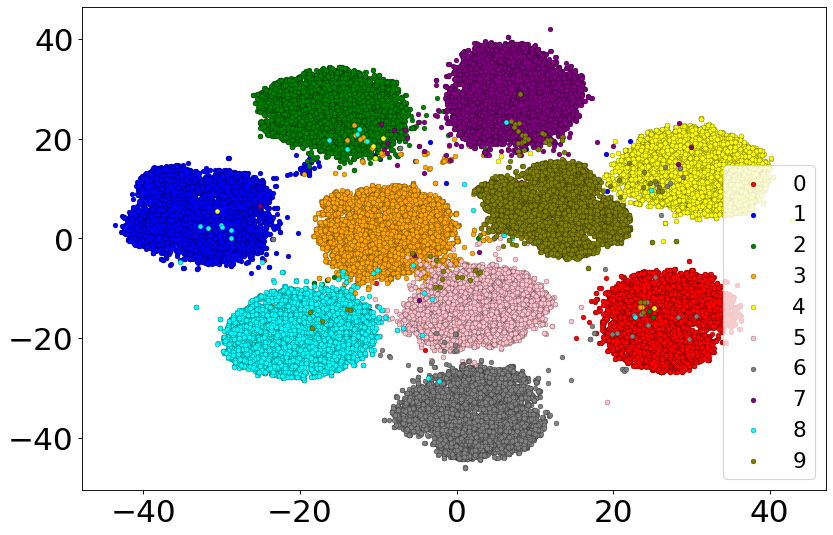

running umap
umap time 76.54520106315613
silhouette average 0.81453806 std 0.17457153
davies bouldin score 0.2561527273686702
calinski harabasz score 358277.04047936416


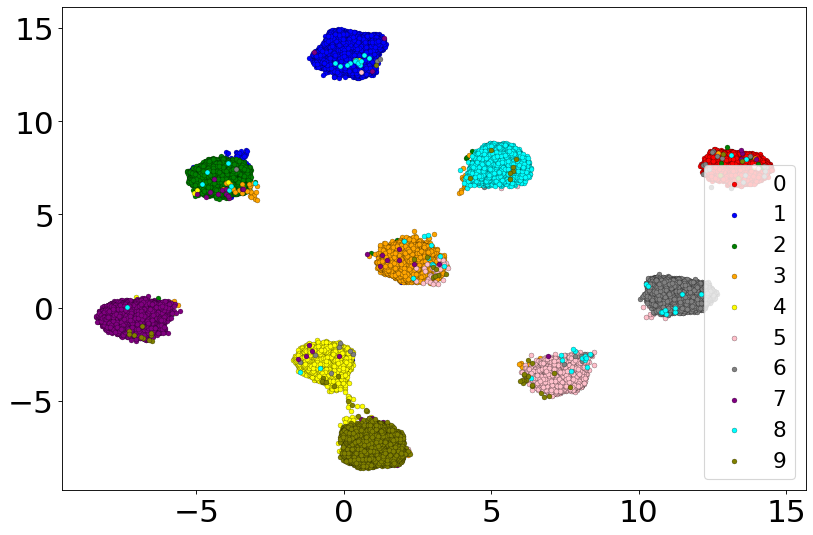

  6%|▌         | 3496/60000 [00:00<00:01, 34953.53it/s]

running ivis
Building KNN index


  2%|▏         | 1061/60000 [00:00<00:05, 10591.00it/s]

Extracting KNN neighbours


100%|██████████| 60000/60000 [00:06<00:00, 9221.98it/s]


Training neural network
Epoch 1/1000
221/469 [=============>................] - ETA: 4s - loss: 0.2242

In [ ]:
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-geometric -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install umap-learn
# !pip install ivis[cpu]

import torch
import sys
import os.path as osp
print(print(torch.__version__))
import torch.nn.functional as F
from torch_geometric.datasets import MNISTSuperpixels, Planetoid, TUDataset
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.nn import SplineConv, voxel_grid, max_pool, max_pool_x
from torch_spline_conv import spline_conv
import torch_cluster
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.io import savemat
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import umap
from ivis import Ivis
import time
import numpy as np
sys.path.append('/content/drive/MyDrive/Thesis')
from visualize_embeddings import *

path = "/content/drive/MyDrive/Thesis/SplineCNN/"
transform = T.Cartesian(cat=False)

# train_dataset = TUDataset(path, 'IMDB-BINARY')
# test_dataset = TUDataset(path, 'IMDB-BINARY')
train_dataset = MNISTSuperpixels(path, True, transform=transform)
test_dataset = MNISTSuperpixels(path, False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
d = train_dataset


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SplineConv(d.num_features, 32, dim=2, kernel_size=5)
        self.conv2 = SplineConv(32, 64, dim=2, kernel_size=5)
        self.conv3 = SplineConv(64, 64, dim=2, kernel_size=5)
        self.fc1 = torch.nn.Linear(4 * 64, 128)
        self.fc2 = torch.nn.Linear(128, d.num_classes)

    def forward(self, data):
        data.x = F.elu(self.conv1(data.x, data.edge_index, data.edge_attr))
        cluster = voxel_grid(data.pos, data.batch, size=5, start=0, end=28)
        data.edge_attr = None
        data = max_pool(cluster, data, transform=transform)

        data.x = F.elu(self.conv2(data.x, data.edge_index, data.edge_attr))
        cluster = voxel_grid(data.pos, data.batch, size=7, start=0, end=28)
        data.edge_attr = None
        data = max_pool(cluster, data, transform=transform)

        data.x = F.elu(self.conv3(data.x, data.edge_index, data.edge_attr))
        cluster = voxel_grid(data.pos, data.batch, size=14, start=0, end=27.99)
        x, _ = max_pool_x(cluster, data.x, data.batch, size=4)

        x = x.view(-1, self.fc1.weight.size(1))
        x = F.elu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        hidden = x
        x = self.fc2(x)
        return hidden, F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train(epoch):
    model.train()

    if epoch == 6:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001

    if epoch == 16:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001

    batch = 1
    for data in train_loader:
        if batch == 1:
          data = data.to(device)
          optimizer.zero_grad()
          hidden,output = model(data)
          F.nll_loss(output, data.y).backward()
          optimizer.step()
          hidden_layer = hidden
          labels = data.y
        if batch > 1:
          data = data.to(device)
          optimizer.zero_grad()
          hidden,output = model(data)
          F.nll_loss(output, data.y).backward()
          optimizer.step()
          hidden_layer = torch.cat((hidden_layer, hidden))
          labels = torch.cat((labels, data.y))
        batch += 1
    return hidden_layer, labels


def test():
    model.eval()
    correct = 0

    batch = 1
    for data in test_loader:
        if batch == 1:
            data = data.to(device)
            hidden, output = model(data)
            pred = output.max(1)[1]
            correct += pred.eq(data.y).sum().item()
            hidden_layer = hidden
            labels = data.y
        if batch >1 :
            data = data.to(device)
            hidden, output = model(data)
            pred = output.max(1)[1]
            correct += pred.eq(data.y).sum().item()
            hidden_layer = torch.cat((hidden_layer,hidden))
            labels = torch.cat((labels, data.y))
        batch += 1
    return hidden_layer, labels, correct / len(test_dataset)


for epoch in range(1, 21):
    hidden_train, labels_train = train(epoch)
    hidden_test, labels_test, test_acc = test()
    hidden_train = hidden_train.cpu().detach().numpy()
    hidden_test = hidden_test.cpu().detach().numpy()
    labels_train = labels_train.cpu().detach().numpy()
    labels_test = labels_test.cpu().detach().numpy()

    if epoch == 20:
                savemat('splinemnist.mat', {'splinemnist_embeddings_train': hidden_train,'splinemnist_node_labels_train': labels_train, 'splinemnist_embeddings_test': hidden_test,'splinemnist_node_labels_test': labels_test})
                num_classes = len(set(labels_train))

                methods = ['pca','tsne','umap','ivis']
                run_visualizations(methods,hidden_embeddings=hidden_train,
                                   labels=labels_train,perplexity=30,neighbors=10,min_dist=0.2,supervised=False)

    print('Epoch: {:02d}, Test: {:.4f}'.format(epoch, test_acc))